In [3]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!unzip -q "/content/gdrive/My Drive/Assignment5/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

gdrive/  hvc_annotations.csv  resized/  sample_data/


In [5]:
#%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConvolution2D
from keras.layers import Activation, Flatten, Dense, Dropout
#from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

In [6]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13573 entries, 0 to 13572
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   gender        13573 non-null  object
 1   imagequality  13573 non-null  object
 2   age           13573 non-null  object
 3   weight        13573 non-null  object
 4   carryingbag   13573 non-null  object
 5   footwear      13573 non-null  object
 6   emotion       13573 non-null  object
 7   bodypose      13573 non-null  object
 8   image_path    13573 non-null  object
dtypes: object(9)
memory usage: 954.5+ KB


In [11]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme()
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_style("white")

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seab

<function matplotlib.pyplot.show(*args, **kw)>

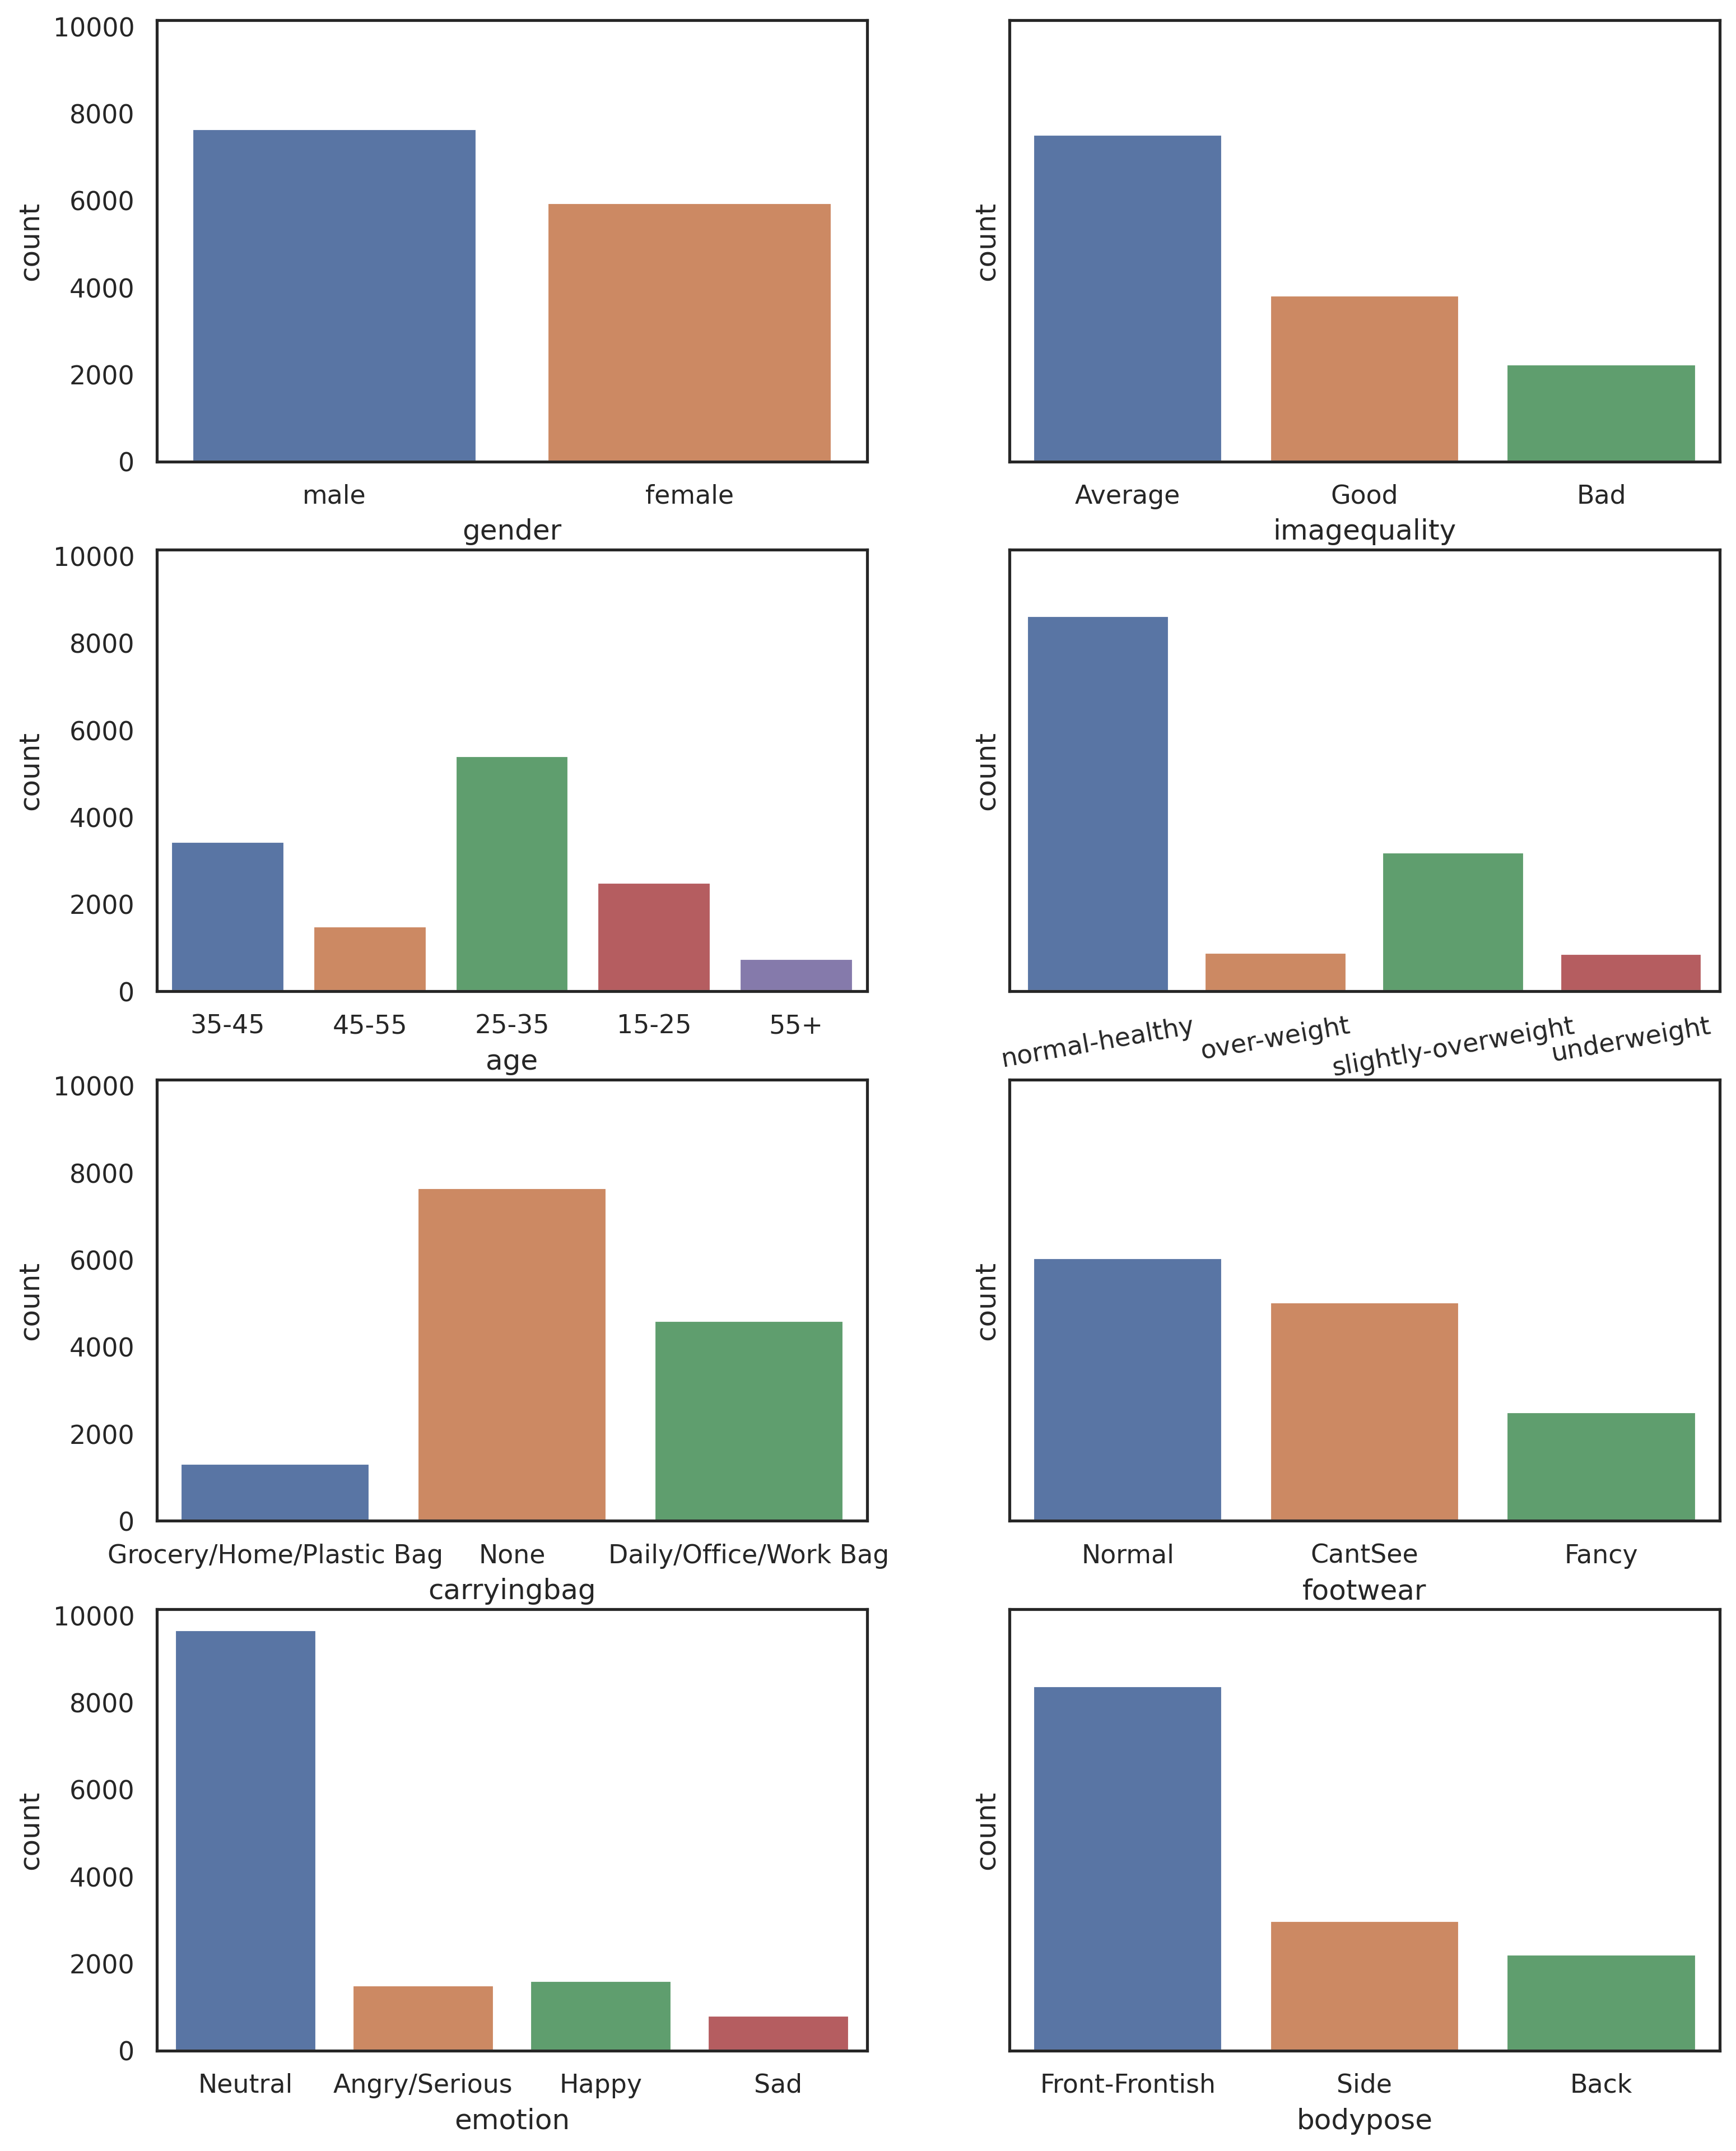

In [25]:
fig, axes = plt.subplots(4, 2, sharey=True, figsize=(12,16))

sns.countplot(df['gender'],ax=axes[0,0])
sns.countplot(df['imagequality'], ax=axes[0,1])
sns.countplot(df['age'], ax=axes[1,0])
sns.countplot(df['weight'], ax=axes[1,1])
sns.countplot(df['carryingbag'],ax=axes[2,0])
sns.countplot(df['footwear'], ax=axes[2,1])
sns.countplot(df['emotion'], ax=axes[3,0])
sns.countplot(df['bodypose'], ax=axes[3,1])

axes[1,1].tick_params(axis='x', labelrotation=10)
plt.show

In [9]:
df['gender'].unique()

array(['male', 'female'], dtype=object)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


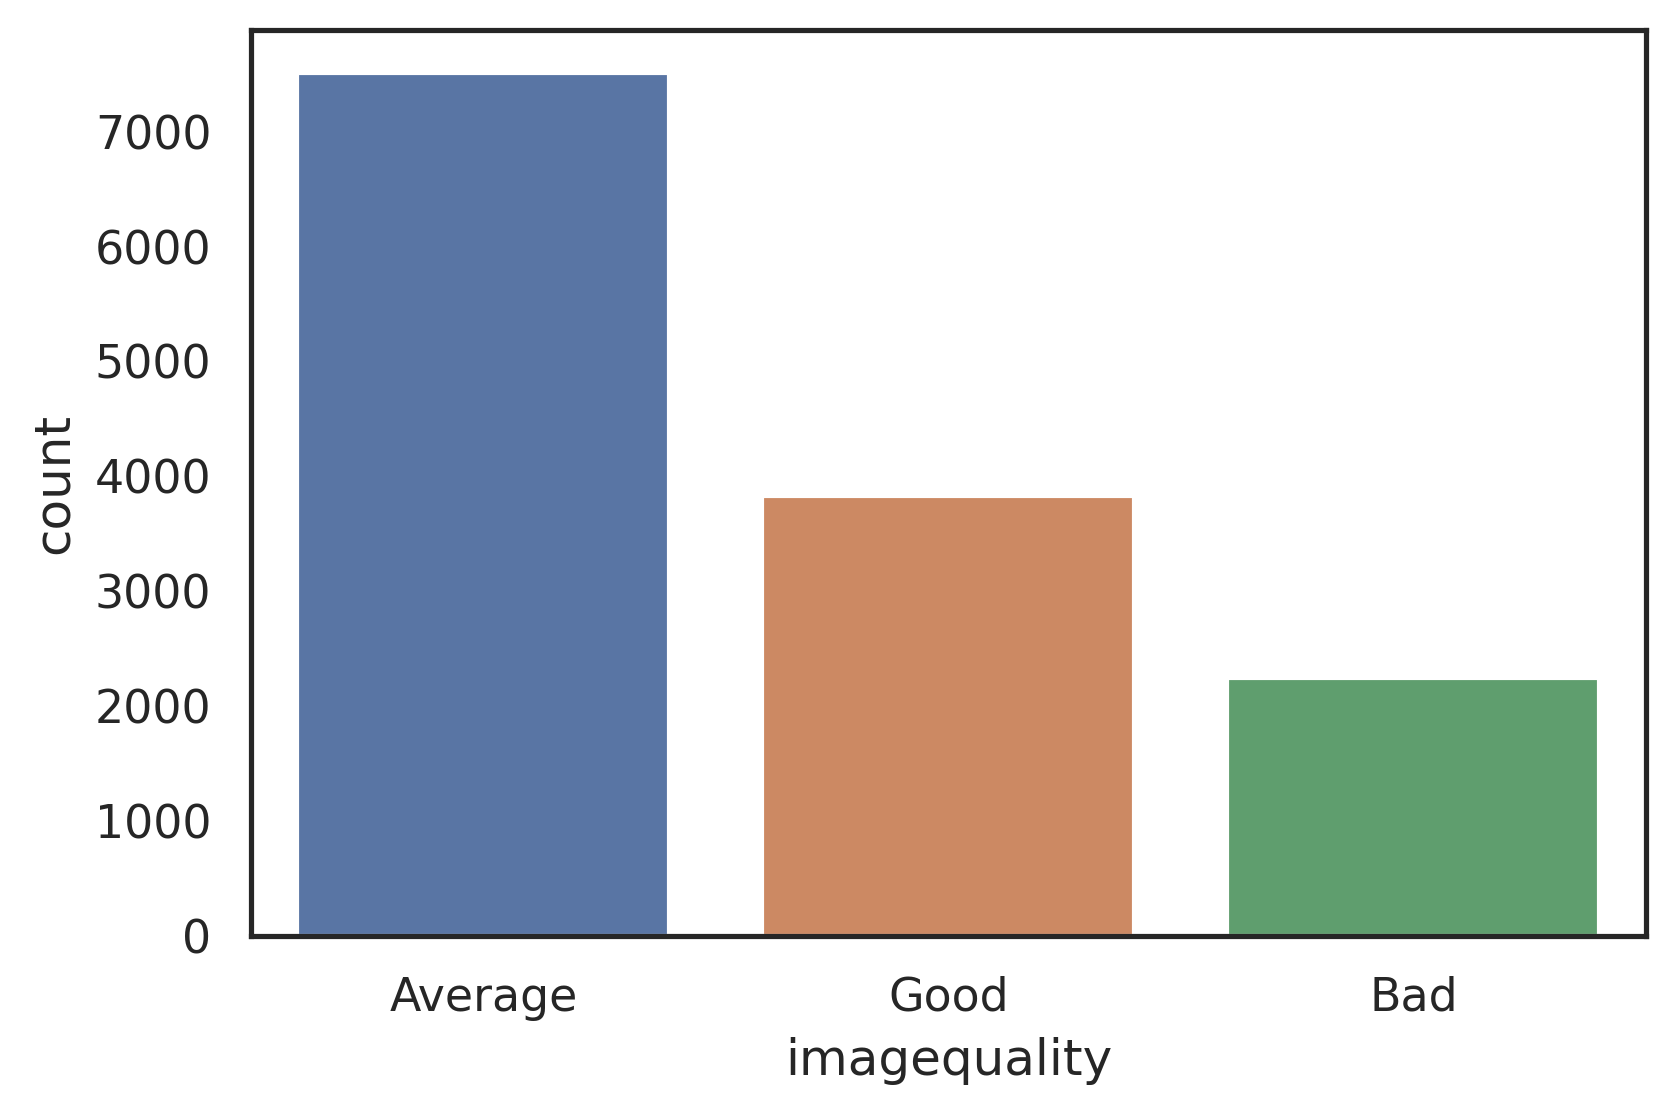

In [17]:
sns.countplot(df['imagequality'])

In [12]:
df['imagequality'].unique()

array(['Average', 'Good', 'Bad'], dtype=object)

In [13]:
df['age'].unique()

array(['35-45', '45-55', '25-35', '15-25', '55+'], dtype=object)

In [14]:
df['weight'].unique()

array(['normal-healthy', 'over-weight', 'slightly-overweight',
       'underweight'], dtype=object)

In [15]:
df['carryingbag'].unique()

array(['Grocery/Home/Plastic Bag', 'None', 'Daily/Office/Work Bag'],
      dtype=object)

In [16]:
df['footwear'].unique()

array(['Normal', 'CantSee', 'Fancy'], dtype=object)

In [17]:
df['emotion'].unique()

array(['Neutral', 'Angry/Serious', 'Happy', 'Sad'], dtype=object)

In [18]:
df['bodypose'].unique()

array(['Front-Frontish', 'Side', 'Back'], dtype=object)

In [11]:
df.columns

Index(['gender', 'imagequality', 'age', 'weight', 'carryingbag', 'footwear',
       'emotion', 'bodypose', 'image_path'],
      dtype='object')

In [ ]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [ ]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, avg_color=np.array([0,0,0])):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        input_img[top:top + h, left:left + w, :] = avg_color

        return input_img

    return eraser

In [ ]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

In [ ]:
class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, train_mean, train_std, batch_size=32, shuffle=True):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.train_mean = train_mean
        self.train_std = train_std
        #self.val = val
        #self.eraser=get_random_eraser()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        images = []
        for image in [cv2.imread(item["image_path"]) for _, item in items.iterrows()]:
          # normalize mean of 0 and stdev of 1
          image = ((image-self.train_mean)/self.train_std).astype('float32') 

          #if not self.val:
            #image = self.eraser(image)
            #image = tf.image.random_flip_left_right(image)
          
          images.append(image)

        images = np.stack(images, axis=0)

        #image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        target= {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        
        return images, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.2, random_state=42)
train_df.shape, val_df.shape

((10858, 28), (2715, 28))

In [ ]:
from tqdm import tnrange, tqdm_notebook
n = 0
s = np.zeros(3)
sq = np.zeros(3)
y = None
for _, item in tqdm_notebook(train_df.iterrows()):
  x = cv2.imread(item["image_path"]).astype('double')
  s += np.sum(x, axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]
  y = x

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))

print(mu, std, n)


[41.34606735 41.56142807 46.62353164] [63.99020204 64.62708368 69.80721893] 544811008


In [ ]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, mu, std, batch_size=16)
valid_gen = PersonDataGenerator(val_df, mu, std, batch_size=16, shuffle=False)

In [ ]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [ ]:
def myModel(input_shape=(224,224,3)):
  model=Sequential()
  model.add(Convolution2D(64, (3, 3), padding='same', input_shape=input_shape, name='B1_C1'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Convolution2D(64, (3, 3), padding='same', name='B1_C2'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2),  strides=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Convolution2D(128, (3, 3), padding='same', name='B2_C1'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Convolution2D(128, (3, 3), padding='same', name='B2_C2'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2),  strides=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Convolution2D(256, (3, 3), padding='same',name='B3_C1'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Convolution2D(256, (3, 3), padding='same', name='B3_C2'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2),  strides=(2, 2), name='MP3'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(512, (3, 3), padding='same',name='B4_C1'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Convolution2D(512, (3, 3), padding='same', name='B4_C2'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Convolution2D(512, (3, 3), padding='same', name='B4_C3'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2),  strides=(2, 2), name='MP4'))
  model.add(Dropout(0.25))

  

  return model

In [ ]:
backbone = myModel()
backbone.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
B1_C1 (Conv2D)               (None, 224, 224, 64)      1792      
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
B1_C2 (Conv2D)               (None, 224, 224, 64)      36928     
_________________________________________________________________
activation_2 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 224, 224, 64)      256 

In [ ]:
neck=backbone.output
print(neck)


Tensor("dropout_4/cond/Merge:0", shape=(?, 14, 14, 512), dtype=float32)


In [ ]:

def build_tower(in_layer):
  neck = Convolution2D(512, (3,3), padding='same', activation='relu' )(in_layer)
  neck = MaxPooling2D(pool_size=(2, 2),  strides=(2, 2))(neck)
  neck = Convolution2D(512, (7, 7), activation='relu')(neck)
  neck = Flatten()(neck)
  '''
  neck = Dense(512, activation="relu")(neck)
  neck = Dropout(0.2)(neck)
  neck = Dense(128, activation="relu")(neck)
  neck = Dropout(0.3)(neck)
  neck = Dense(128, activation="relu")(neck)'''
  return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))

age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))

bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))

emotion = build_head("emotion", build_tower(neck))

pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

In [ ]:
print(backbone.input)

Tensor("B1_C1_input_4:0", shape=(?, 224, 224, 3), dtype=float32)


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
B1_C1_input (InputLayer)        (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
B1_C1 (Conv2D)                  (None, 224, 224, 64) 1792        B1_C1_input[0][0]                
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 64) 0           B1_C1[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 64) 256         activation_1[0][0]               
____________________________________________________________________________________________

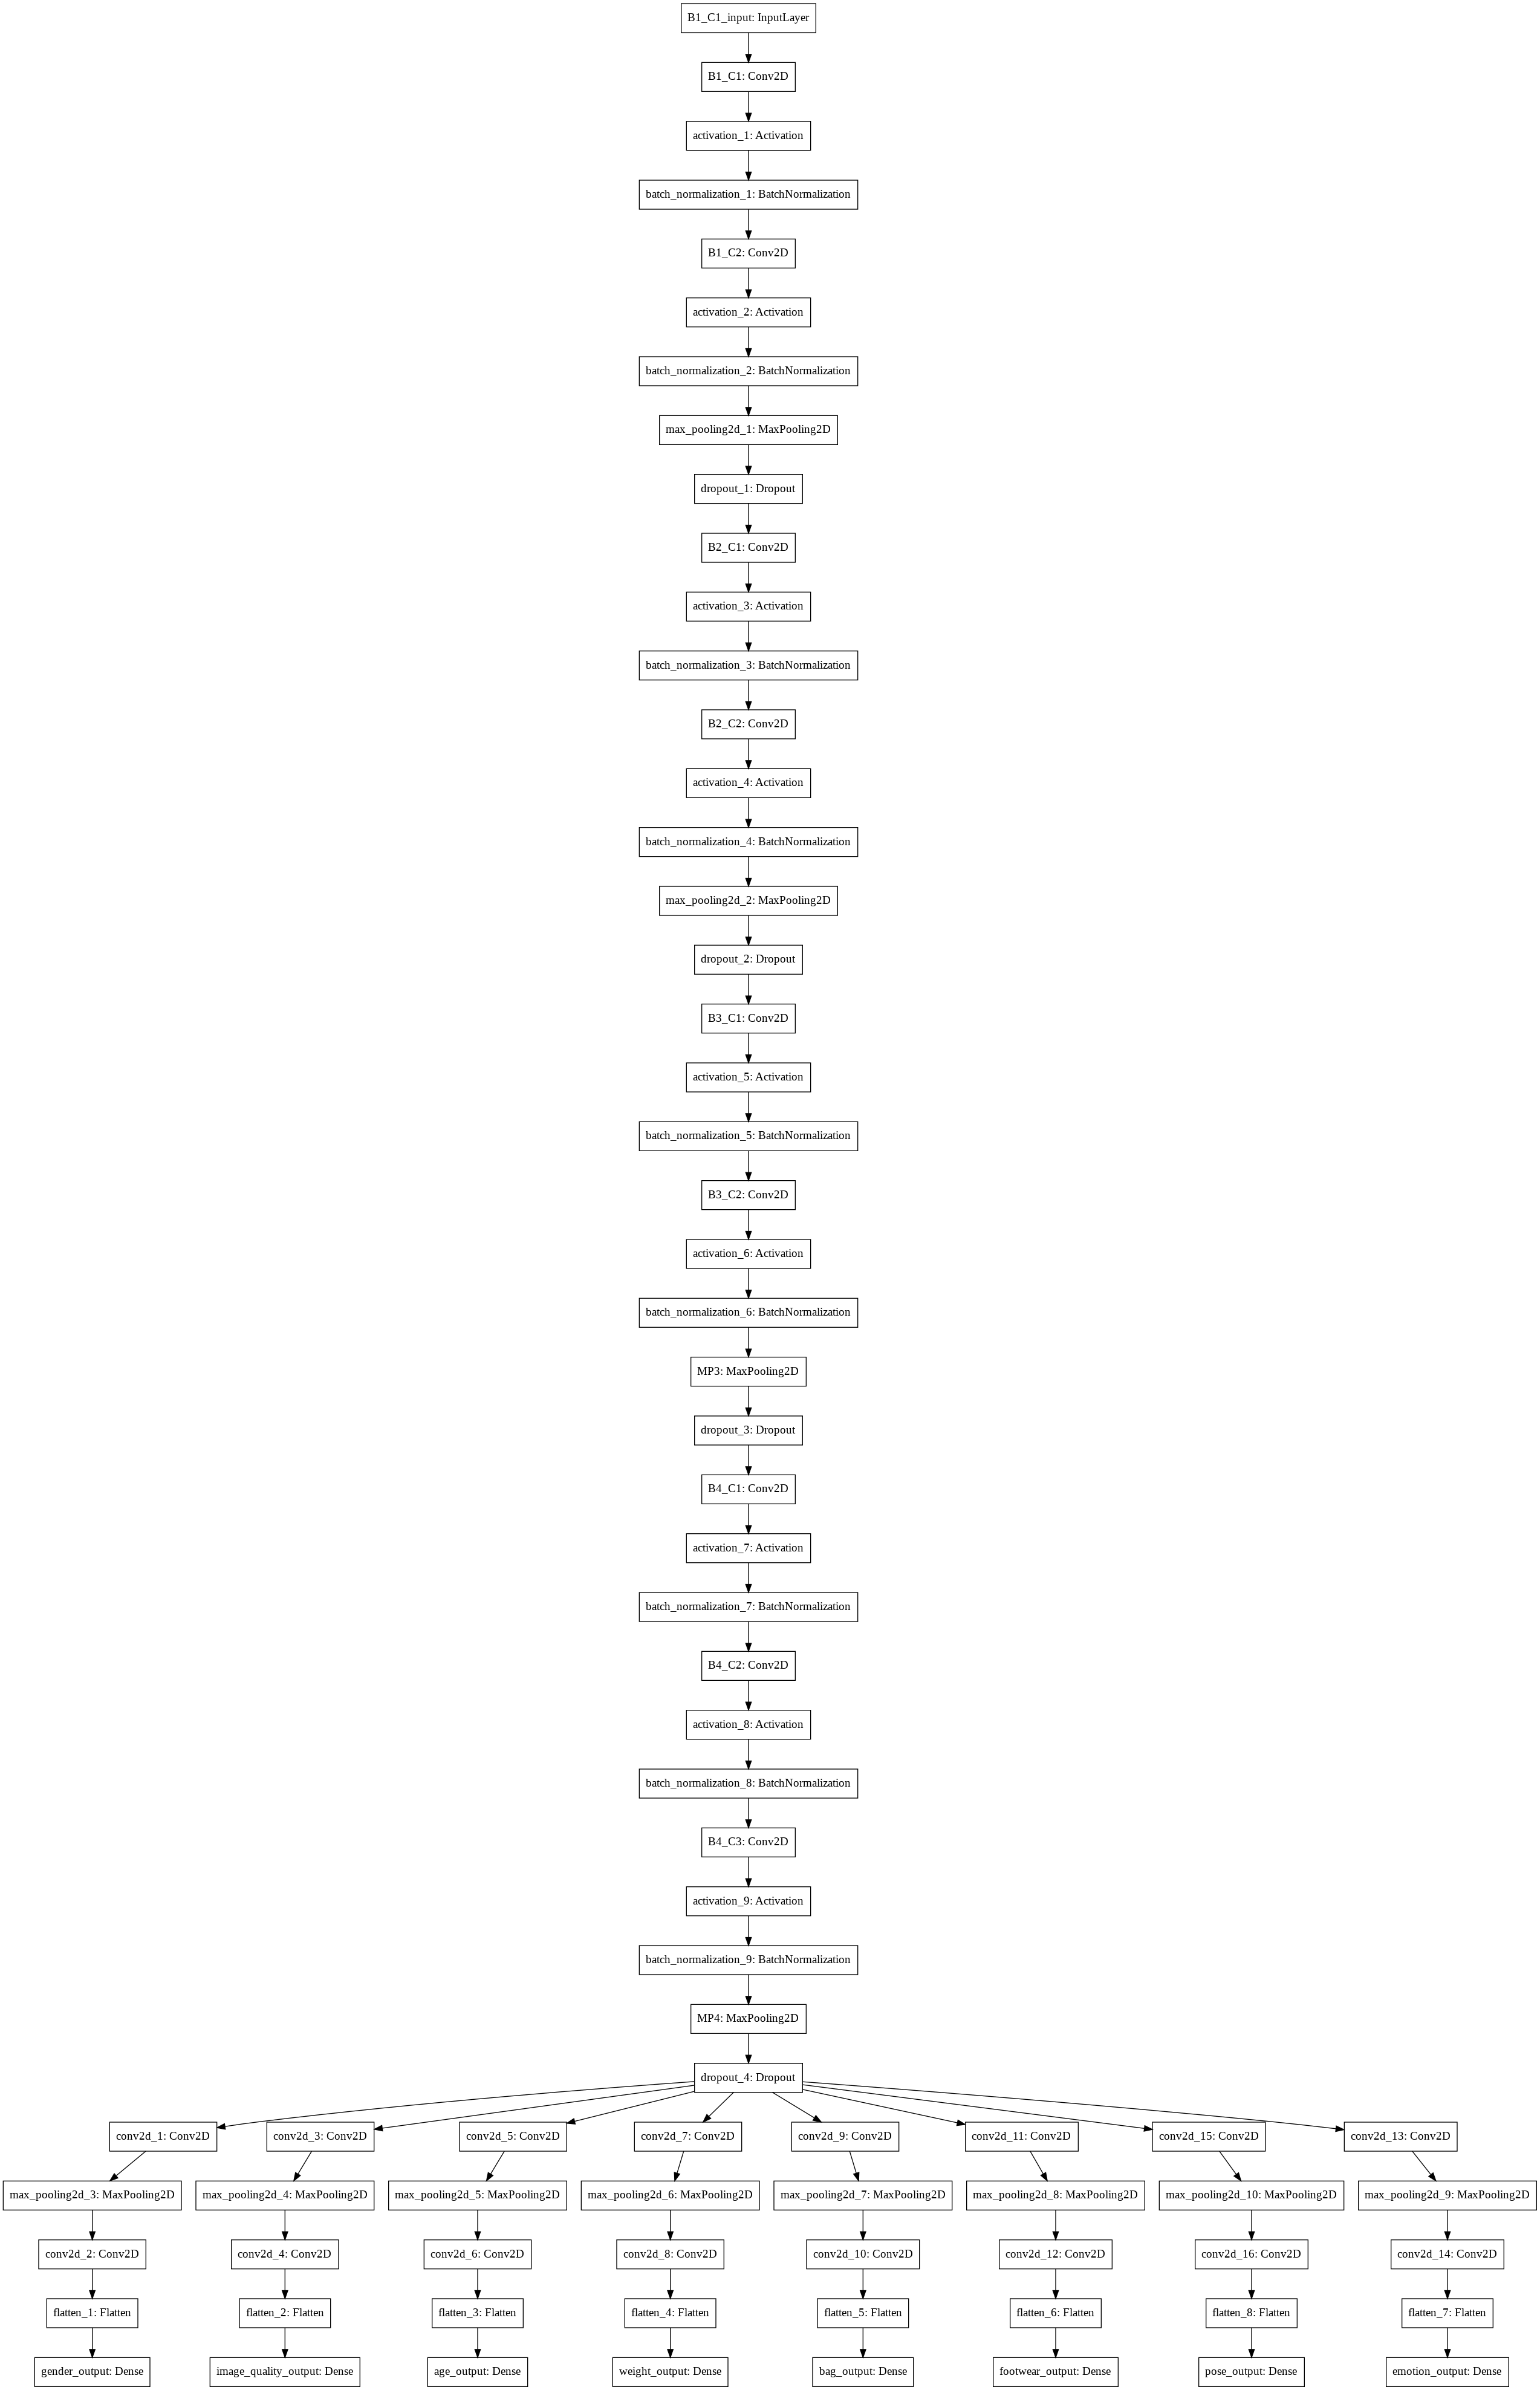

In [ ]:
from keras.utils import plot_model
plot_model(model)

In [ ]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [ ]:
clr = CyclicLR(base_lr=0.001, max_lr=0.06, step_size=2000., mode='triangular2')

In [ ]:
opt = SGD(lr=0.001,momentum=0.9)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [ ]:
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=24,
    verbose=1,
      )

Epoch 1/24
678/678 [==============================] - 211s 311ms/step - loss: 69.1601 - gender_output_loss: 7.0086 - image_quality_output_loss: 13.4496 - age_output_loss: 9.6816 - weight_output_loss: 12.2773 - bag_output_loss: 7.0234 - footwear_output_loss: 8.9401 - pose_output_loss: 6.1483 - emotion_output_loss: 4.6313 - gender_output_acc: 0.5652 - image_quality_output_acc: 0.1656 - age_output_acc: 0.3993 - weight_output_acc: 0.2383 - bag_output_acc: 0.5643 - footwear_output_acc: 0.4453 - pose_output_acc: 0.6185 - emotion_output_acc: 0.7127 - val_loss: 69.9623 - val_gender_output_loss: 7.2186 - val_image_quality_output_loss: 13.4774 - val_age_output_loss: 9.7460 - val_weight_output_loss: 12.5237 - val_bag_output_loss: 7.0934 - val_footwear_output_loss: 8.9711 - val_pose_output_loss: 6.2171 - val_emotion_output_loss: 4.7150 - val_gender_output_acc: 0.5521 - val_image_quality_output_acc: 0.1638 - val_age_output_acc: 0.3953 - val_weight_output_acc: 0.2230 - val_bag_output_acc: 0.5599 - v

In [ ]:
history=model.history

In [ ]:
#print(history.history.keys())
for x in history.history.keys():
  if x.startswith('val') and x.endswith('acc'):
    print(x, " -- ",  history.history[x][-1])

val_gender_output_acc  --  0.5521449704142012
val_image_quality_output_acc  --  0.16383136094674555
val_age_output_acc  --  0.3953402366863905
val_weight_output_acc  --  0.22300295857988164
val_bag_output_acc  --  0.5599112426035503
val_footwear_output_acc  --  0.4434171597633136
val_pose_output_acc  --  0.6142751479289941
val_emotion_output_acc  --  0.7074704142011834


In [ ]:
print('gender : ', max(history.history['val_gender_output_acc']))
print('image quality : ', max(history.history['val_image_quality_output_acc']))
print('age : ', max(history.history['val_age_output_acc']))
print('weight : ', max(history.history['val_weight_output_acc']))
print('bag : ', max(history.history['val_bag_output_acc']))
print('footwear : ', max(history.history['val_footwear_output_acc']))
print('pose : ', max(history.history['val_pose_output_acc']))
print('emotion : ', max(history.history['val_emotion_output_acc']))

gender :  0.5521449704142012
image quality :  0.16383136094674555
age :  0.3953402366863905
weight :  0.22300295857988164
bag :  0.5599112426035503
footwear :  0.4434171597633136
pose :  0.6142751479289941
emotion :  0.7074704142011834


In [ ]:
history=model.history

In [ ]:
val_loss=[]
for i in range(24):
  sum=0
  l = ['val_gender_output_loss','val_image_quality_output_loss',  'val_age_output_loss', 'val_weight_output_loss', 'val_bag_output_loss', 'val_footwear_output_loss', 'val_pose_output_loss',
 'val_emotion_output_loss']
  for x in l:
    sum += history.history[x][i]
  val_loss.append(sum)
print(val_loss)

[69.96231007717066, 69.96231007717066, 69.96231007717066, 69.96231007717066, 69.96231007717066, 69.96231007717066, 69.96231007717066, 69.96231007717066, 69.96231007717066, 69.96231007717066, 69.96231007717066, 69.96231007717066, 69.96231007717066, 69.96231007717066, 69.96231007717066, 69.96231007717066, 69.96231007717066, 69.96231007717066, 69.96231007717066, 69.96231007717066, 69.96231007717066, 69.96231007717066, 69.96231007717066, 69.96231007717066]


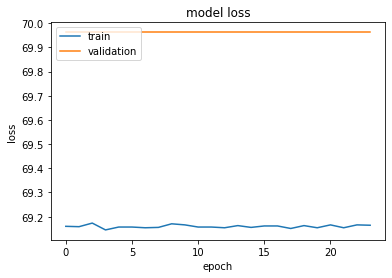

In [ ]:
  import matplotlib.pyplot as plt
  plt.plot(history.history['loss'])
  plt.plot(val_loss)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()  #no reduction in validation loss

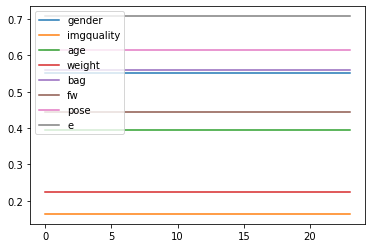

In [ ]:
plt.plot(history.history['val_gender_output_acc'])
plt.plot(history.history['val_image_quality_output_acc'])
plt.plot(history.history['val_age_output_acc'])
plt.plot(history.history['val_weight_output_acc'])
plt.plot(history.history['val_bag_output_acc'])
plt.plot(history.history['val_footwear_output_acc'])
plt.plot(history.history['val_pose_output_acc'])
plt.plot(history.history['val_emotion_output_acc'])
plt.legend(['gender', 'imgquality','age','weight', 'bag','fw','pose','e'], loc='upper left')
plt.show()